In [ ]:
import pickle
import matplotlib.pyplot as plt
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import EmpiricalCovariance
import torch
#from training import register_esmart_wip,get_cfg,build_detection_test_loader
from detectron2.config import get_cfg
from detectron2.data import build_detection_test_loader,build_detection_train_loader
from detectron2.data.datasets import register_coco_instances
from detectron2.modeling import build_model
from detectron2 import model_zoo
from detectron2.structures import Boxes,Instances
import detectron2.data.transforms as T
from detectron2.checkpoint import DetectionCheckpointer
import cv2
import copy
from detectron2.layers import batched_nms
from detectron2.engine import DefaultPredictor
from detectron2.data import MetadataCatalog
from detectron2.utils.visualizer import Visualizer 

#embed_classwise = {}
#fea_path = "ood_distance/checkpoints/esmart/coco_features/gt/box"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [ ]:
cfg = get_cfg()
#cfg.merge_from_file("/home/vaibhav/Desktop/stud/configs/BDD100k/stud_resnet.yaml")
#cfg = model_zoo.get_config(config_path="COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml",trained=False)  # Use the appropriate config file
cfg.merge_from_file("/home/mila/v/vaibhav.jade/scratch/intern/ood_distance/configs/finetune_bigdet_trained.yaml")
#cfg._BASE_ = "/home/mila/v/vaibhav.jade/scratch/intern/stud/configs/Base-RCNN-FPN.yaml"
#cfg.DATASETS.TEST = ("esmart_wip",)

cfg.MODEL.WEIGHTS = "/home/mila/v/vaibhav.jade/scratch/intern/ood_distance/checkpoints/esmart/bigdet_finetune_on_esmart/model_final.pth"
#test_data_loader = build_detection_train_loader(cfg)

model = build_model(cfg)
checkpointer = DetectionCheckpointer(model)
checkpointer.load(cfg.MODEL.WEIGHTS)


cfg.merge_from_file("/home/mila/v/vaibhav.jade/scratch/intern/ood_distance/configs/bigdet_trained.yaml")
cfg.MODEL.WEIGHTS = "/home/mila/v/vaibhav.jade/scratch/intern/ood_distance/checkpoints/faster_rcnn_r50_fpn_bigdet_8x.pth"

#cfg.MODEL.WEIGHTS = "/home/mila/v/vaibhav.jade/scratch/intern/ood_distance/checkpoints/model_final_b275ba.pkl"
coco_model = build_model(cfg)
checkpointer = DetectionCheckpointer(coco_model)
checkpointer.load(cfg.MODEL.WEIGHTS)
coco_model.eval()
predictor = DefaultPredictor(cfg)

In [ ]:
model.eval()
model.requires_grad_(False)


In [4]:
cfg.merge_from_file("/home/mila/v/vaibhav.jade/scratch/intern/ood_distance/configs/finetune_coco_trained.yaml")
cfg.MODEL.WEIGHTS = "/home/mila/v/vaibhav.jade/scratch/intern/ood_distance/checkpoints/esmart/coco_finetune_on_esmart/model_final.pth"
#cfg.merge_from_file("/home/mila/v/vaibhav.jade/scratch/intern/ood_distance/configs/coco_trained.yaml")

#cfg.MODEL.WEIGHTS = "/home/mila/v/vaibhav.jade/scratch/intern/ood_distance/checkpoints/model_final_b275ba.pkl"
#cfg.MODEL.WEIGHTS = "/home/mila/v/vaibhav.jade/scratch/intern/ood_distance/checkpoints/faster_rcnn_r50_fpn_bigdet_8x.pth"
#predictor = DefaultPredictor(cfg)

Config '/home/mila/v/vaibhav.jade/scratch/intern/ood_distance/configs/finetune_coco_trained.yaml' has no VERSION. Assuming it to be compatible with latest v2.


In [27]:
image = cv2.imread("/home/mila/v/vaibhav.jade/scratch/intern/ood_distance/notebooks/montreal-construction.jpeg")
height, width = image.shape[:2]
num_classes = 12
magnitude = 0.01
aug = T.ResizeShortestEdge(
    [cfg.INPUT.MIN_SIZE_TEST, cfg.INPUT.MIN_SIZE_TEST], cfg.INPUT.MAX_SIZE_TEST
    )
im = aug.get_transform(image).apply_image(image)
im = torch.as_tensor(image.astype("float32").transpose(2, 0, 1))
im.to(device)

inputs = {"image": im, "height": height, "width": width}


/home/mila/v/vaibhav.jade/detectron2/lib/python3.7/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


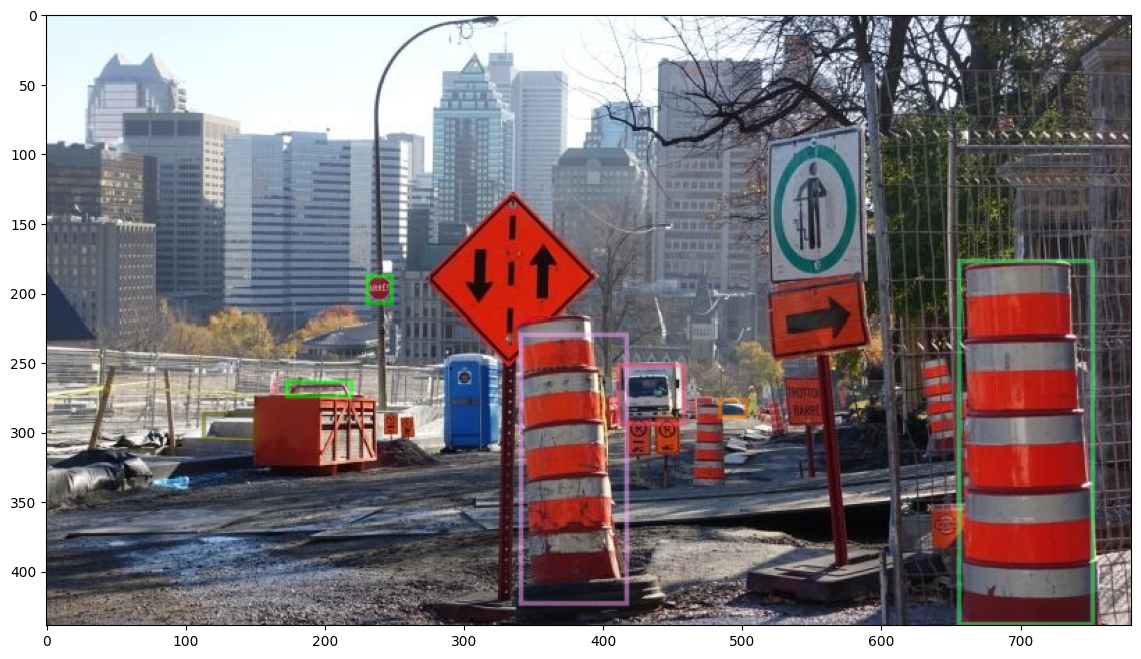

In [28]:
outputs = predictor(image)
v_pred = Visualizer(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), None)
#v_pred = v_pred.draw_instance_predictions(outputs["instances"].to("cpu"))
v_pred = v_pred.overlay_instances(
    boxes= outputs['instances'].pred_boxes.tensor.detach().cpu(),
    #labels = labels
    #labels = ["ood " if i==1 else "id " for i in predictions.pred_classes]
)
plt.figure(figsize = (14, 10))
plt.imshow(v_pred.get_image())

In [29]:
outputs

{'instances': Instances(num_instances=7, image_height=439, image_width=780, fields=[pred_boxes: Boxes(tensor([[230.9155, 188.4200, 248.0668, 206.6877],
         [656.4849, 177.0030, 752.2354, 437.9042],
         [340.6237, 229.9380, 417.2627, 423.4198],
         [173.4544, 263.6410, 218.7826, 273.8240],
         [483.5026, 277.3364, 503.1032, 288.6660],
         [112.9023, 287.2609, 150.2943, 304.7575],
         [411.1407, 251.6891, 457.8786, 293.5152]], device='cuda:0')), scores: tensor([0.9674, 0.8863, 0.8342, 0.7955, 0.7912, 0.7516, 0.5533],
        device='cuda:0'), pred_classes: tensor([9, 7, 7, 2, 2, 2, 1], device='cuda:0')])}

In [30]:
prop_preds = model([inputs])[0]
prop_preds

{'instances': Instances(num_instances=3, image_height=439, image_width=780, fields=[pred_boxes: Boxes(tensor([[278.5261, 134.8245, 390.6486, 237.0718],
         [482.3390, 276.0683, 503.1782, 288.7172],
         [230.6139, 188.1941, 249.0531, 205.6441]], device='cuda:0')), scores: tensor([0.9307, 0.8948, 0.8561], device='cuda:0'), pred_classes: tensor([7, 2, 9], device='cuda:0')])}

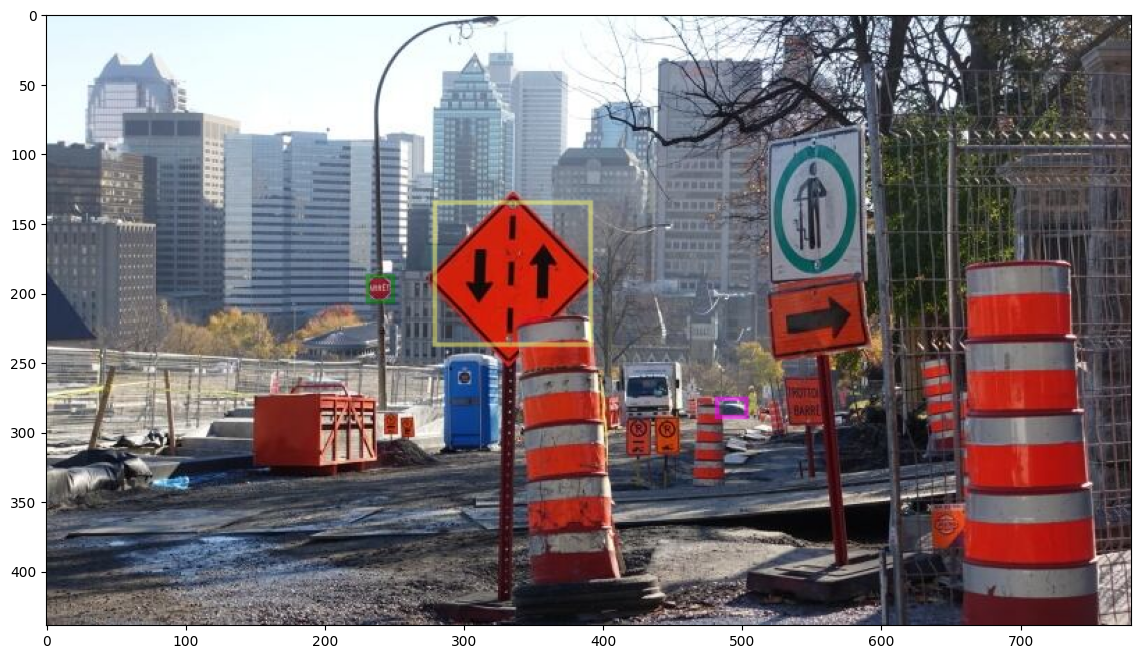

In [32]:
v_pred = Visualizer(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), None)
#v_pred = v_pred.draw_instance_predictions(prop_preds["instances"].to("cpu"))
v_pred = v_pred.overlay_instances(
    boxes= prop_preds['instances'].pred_boxes.tensor.detach().cpu(),
    #labels = labelss
    #labels = ["ood " if i==1 else "id " for i in predictions.pred_classes]
)
plt.figure(figsize = (14, 10))
plt.imshow(v_pred.get_image())

In [36]:
def sample_estimator(embed_classwise,num_classes):
    classwise_mean = np.zeros((num_classes,embed_classwise[0][0].shape[0]),dtype='float32')
    precision = []
    X = None
    group_lasso = EmpiricalCovariance(assume_centered=False)
    for c in embed_classwise.keys():
        f_x = np.array(embed_classwise[c])
        classwise_mean[c] = f_x.mean(axis=0)
        f_x = f_x - classwise_mean[c][np.newaxis,:]
        if c == list(embed_classwise.keys())[0]:
             X = f_x
        else:
            np.concatenate((X,f_x),axis=0)
        ### finding inverse of covariance
    group_lasso.fit(X)
    precision = group_lasso.precision_
    #precision = np.array(precision)
   

    return torch.from_numpy(classwise_mean).float().to(device),torch.from_numpy(precision).float().to(device)

embed_classwise = {}
fea_path = "/home/mila/v/vaibhav.jade/scratch/intern/ood_distance/checkpoints/esmart/coco_features/gt/box"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for im in os.listdir(fea_path):
    x = {}
    with open(os.path.join(fea_path,im), 'rb') as f:
        x = pickle.load(f)
        
    idx = 0
    for i in x['preds']:
        if embed_classwise.get(i.item()) == None:
            embed_classwise[i.item()] = [x['features'][idx].detach().cpu().numpy()]
        else:
            embed_classwise[i.item()].append(x['features'][idx].detach().cpu().numpy())
        idx += 1      

In [37]:
sample_mean,precision = sample_estimator(embed_classwise,12)

copy_model = copy.deepcopy(model)
copy_model.eval()
copy_model.requires_grad_(False)
sample_mean.requires_grad_(False)
precision.requires_grad_(False)

tensor([[ 1.1014e+02,  1.0313e+00,  1.7571e+00,  ...,  2.3133e+00,
          2.1826e+00, -4.6051e+00],
        [ 1.0313e+00,  1.0364e+02,  9.9066e+00,  ..., -6.6084e+00,
         -3.5068e-01,  2.2112e+00],
        [ 1.7571e+00,  9.9066e+00,  1.0996e+02,  ...,  2.8324e+00,
         -1.3445e-01,  1.4971e+01],
        ...,
        [ 2.3133e+00, -6.6084e+00,  2.8324e+00,  ...,  8.6505e+02,
          1.0698e+01,  2.4251e+01],
        [ 2.1826e+00, -3.5068e-01, -1.3445e-01,  ...,  1.0698e+01,
          4.7437e+01,  1.1101e+01],
        [-4.6051e+00,  2.2112e+00,  1.4971e+01,  ...,  2.4251e+01,
          1.1101e+01,  2.2474e+03]], device='cuda:0')

In [58]:
def get_features(model, inputs, instances = None,is_inference=False):
    
    def hook(module, input, output):
                features.append(output)
    
    ### hooks to get feature maps from backbone 
    h = model.backbone.register_forward_hook(hook)
    features = []
    predictions = model([inputs])[0]
    h.remove()

    # Get detection instances
    if instances == None:
        instances = predictions['instances']

    # Get detected boxes and extract corresponding feature embeddings
    ### detaching predictions from computation graph
    if is_inference:
        pred_boxes = Boxes(torch.concat([instances,predictions['instances'].pred_boxes.tensor],dim=0))  # Prediction boxes (x1, y1, x2, y2)
    else:
        pred_boxes = Boxes(instances)
    roi_pooler = model.roi_heads.box_pooler  # ROI feature extractor
    feature_extractor = model.roi_heads.box_head

    pooled_features = roi_pooler([features[0][f] for f in model.roi_heads.in_features], [pred_boxes])
    roi_features = feature_extractor(pooled_features)

    return pred_boxes.tensor, roi_features,predictions



In [70]:
sample_mean = sample_mean.squeeze()

In [76]:

Mahalanobis = []
input_path = "/home/mila/v/vaibhav.jade/scratch/intern/ood_distance/notebooks/montreal-construction.jpeg"
num_classes = 12
magnitude = 0.01

image = cv2.imread(input_path)
height, width = image.shape[:2]
num_classes = 12
magnitude = 0.01
aug = T.ResizeShortestEdge(
    [cfg.INPUT.MIN_SIZE_TEST, cfg.INPUT.MIN_SIZE_TEST], cfg.INPUT.MAX_SIZE_TEST
    )
inp_image = aug.get_transform(image).apply_image(image)
inp_image = torch.as_tensor(inp_image.astype("float32").transpose(2, 0, 1))
inp_image = inp_image.to(device).requires_grad_(True)

im = {"image": inp_image, "height": height, "width": width}

### forward pass and roi pooling features
### Warning! instances here is still connected to graph,
### pass it under no_grad() context or be careful    
# instances,out_features = get_features_for_proposals(model,im)

# out_nms = batched_nms(instances.proposal_boxes.tensor,instances.objectness_logits,torch.ones_like(instances.objectness_logits),0.5)
# min_idx = min(20,len(out_nms))
# prop_boxes = instances.proposal_boxes.tensor.detach()[out_nms[:min_idx]]
# out_features = out_features[out_nms[:min_idx]]

# compute Mahalanobis score
coco_preds = predictor(image)
#coco_preds =  coco_model([im])[0]

prop_boxes,out_features,predictions = get_features(model,im,coco_preds['instances'].pred_boxes.tensor.detach(),is_inference=True)
#prop_boxes,out_features = get_features(model,im,gt)    

gaussian_score = 0
out_features = torch.unsqueeze(out_features,1)
#sample_mean = torch.unsqueeze(sample_mean,0)
zero_f = out_features - torch.unsqueeze(sample_mean,0)     #shape b,n_c,1024
### (b,n_c,1024) x (1024,1024) x (b,1024,n_c)= (b,n_c,n_c)
gaussian_score = torch.matmul(torch.matmul(zero_f,precision), torch.transpose(zero_f,1,2))
### taking diag() of (n_c,n_c) matrices
gaussian_score = gaussian_score*torch.eye(num_classes,num_classes,device=device)
gaussian_score = -0.5*gaussian_score.sum(dim=-1)

### there's no need to calculate again as its the same calculation
loss = -(gaussian_score).max(dim=1)[0]

for l in range(len(loss)):
    if l == len(loss) - 1:
        model.zero_grad()
        #inp_image.grad = None
        loss[l].backward()
    else:
        model.zero_grad()
        inp_image.grad = None
        loss[l].backward(retain_graph=True)
    ### sign function on gradients
    gradient =  torch.ge(inp_image.grad, 0)
    gradient = (gradient.float() - 0.5) * 2

    ### scaling the gradient by image preprocessing std in original code, 
    ### not needed as its 1 in FasterRCNN, subject to specific case

    # gradient.index_copy_(1, torch.LongTensor([0]).cuda(), gradient.index_select(1, torch.LongTensor([0]).cuda()) / (model.pixel_std[0]))
    # gradient.index_copy_(1, torch.LongTensor([1]).cuda(), gradient.index_select(1, torch.LongTensor([1]).cuda()) / (model.pixel_std[1]))
    # gradient.index_copy_(1, torch.LongTensor([2]).cuda(), gradient.index_select(1, torch.LongTensor([2]).cuda()) / (model.pixel_std[2]))

    tempInputs = torch.add(inp_image, -magnitude, gradient)

    with torch.no_grad():

        _,noise_out_features,_ = get_features(copy_model,{"image": tempInputs, "height": height, "width": width},prop_boxes)

        noise_gaussian_score = 0
        noise_out_features = torch.unsqueeze(noise_out_features[l],0)
        noise_zero_f = noise_out_features - sample_mean.squeeze()     #shape b,n_c,1024
        ### (b,n_c,1024) x (1024,1024) x (b,1024,n_c)= (b,n_c,n_c)
        noise_gaussian_score = -0.5*torch.mm(torch.mm(noise_zero_f,precision), noise_zero_f.t()).diag()

        noise_gaussian_score = torch.max(noise_gaussian_score)
        Mahalanobis.append(noise_gaussian_score.cpu().numpy())

ood_preds = torch.tensor(np.asarray(Mahalanobis)) < -10000.0
ood_preds = ood_preds*1
final_preds = batched_nms(prop_boxes,torch.tensor(np.asarray(Mahalanobis)).abs().to(device),torch.ones_like(ood_preds),0.7)
print(ood_preds,final_preds,prop_boxes)
pred_instances = Instances((height,width))
pred_instances.pred_boxes = Boxes(prop_boxes)[final_preds]
pred_instances.pred_classes = (ood_preds + 1)[final_preds]
pred_instances.mahal_scores = torch.tensor(np.asarray(Mahalanobis))[final_preds]


/home/mila/v/vaibhav.jade/detectron2/lib/python3.7/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) tensor([ 8, 10,  0, 11,  6, 12,  2], device='cuda:0') tensor([[230.9155, 188.4200, 248.0668, 206.6877],
        [656.4849, 177.0030, 752.2354, 437.9042],
        [340.6237, 229.9380, 417.2627, 423.4198],
        [173.4544, 263.6410, 218.7826, 273.8240],
        [483.5026, 277.3364, 503.1032, 288.6660],
        [112.9023, 287.2609, 150.2943, 304.7575],
        [411.1407, 251.6891, 457.8786, 293.5152],
        [230.9154, 188.4202, 248.0669, 206.6876],
        [656.4874, 177.0030, 752.2363, 437.9041],
        [340.6234, 229.9250, 417.2613, 423.4249],
        [173.4567, 263.6417, 218.7829, 273.8240],
        [483.5032, 277.3364, 503.1029, 288.6656],
        [112.9004, 287.2607, 150.2940, 304.7580],
        [411.1429, 251.6893, 457.8770, 293.5130]], device='cuda:0',
       grad_fn=<CatBackward0>)


In [78]:
prop_boxes,ood_preds,pred_instances,predictions

(tensor([[230.9155, 188.4200, 248.0668, 206.6877],
         [656.4849, 177.0030, 752.2354, 437.9042],
         [340.6237, 229.9380, 417.2627, 423.4198],
         [173.4544, 263.6410, 218.7826, 273.8240],
         [483.5026, 277.3364, 503.1032, 288.6660],
         [112.9023, 287.2609, 150.2943, 304.7575],
         [411.1407, 251.6891, 457.8786, 293.5152],
         [230.9154, 188.4202, 248.0669, 206.6876],
         [656.4874, 177.0030, 752.2363, 437.9041],
         [340.6234, 229.9250, 417.2613, 423.4249],
         [173.4567, 263.6417, 218.7829, 273.8240],
         [483.5032, 277.3364, 503.1029, 288.6656],
         [112.9004, 287.2607, 150.2940, 304.7580],
         [411.1429, 251.6893, 457.8770, 293.5130]], device='cuda:0',
        grad_fn=<CatBackward0>),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 Instances(num_instances=7, image_height=439, image_width=780, fields=[pred_boxes: Boxes(tensor([[656.4874, 177.0030, 752.2363, 437.9041],
         [173.4567, 263.6417, 218.7829, 273

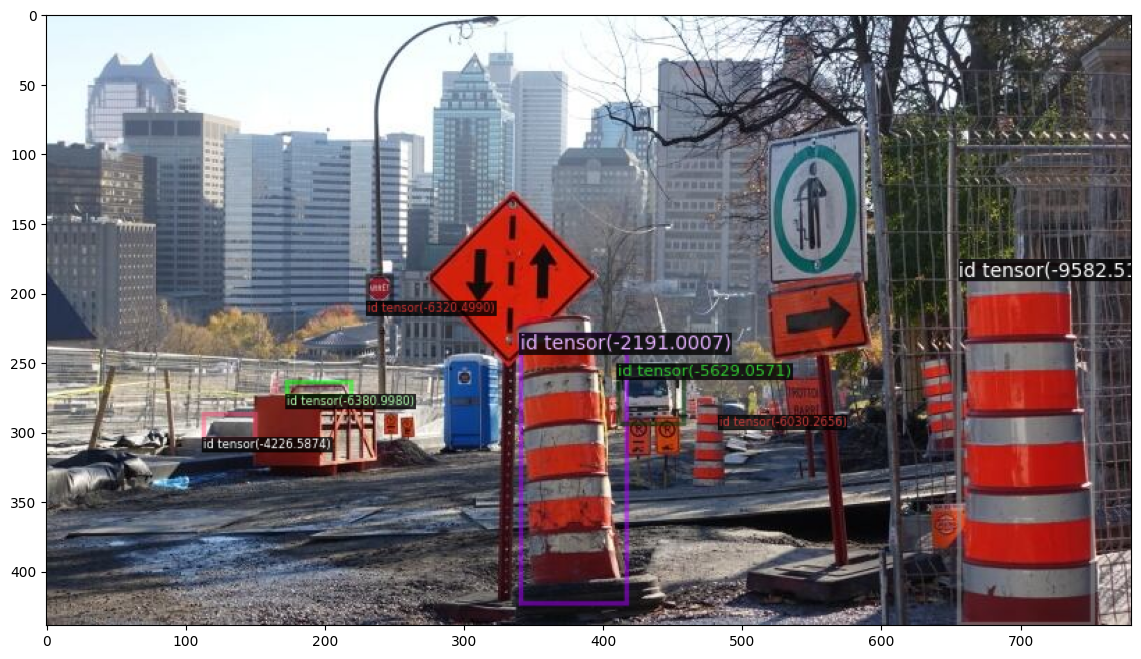

In [82]:
v_pred = Visualizer(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), None)
#v_pred = v_pred.draw_instance_predictions(prop_preds["instances"].to("cpu"))
v_pred = v_pred.overlay_instances(
    boxes= pred_instances.pred_boxes.tensor.detach().cpu(),
    #labels = labelss
    labels = ["ood "+str(score) if i==2 else "id "+str(score) for i,score in zip(pred_instances.pred_classes,pred_instances.mahal_scores)]
)
plt.figure(figsize = (14, 10))
plt.imshow(v_pred.get_image())